In [1]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.patheffects
import textwrap
import squarify

## import terminals data from sheet

In [2]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
#spreadsheet = gc.open_by_key('1hOuMDpznpTKQRJ9SQGWY1ktMR_qw0vVRARrAtgeUsYQ') # Nov 28 2023 file
spreadsheet = gc.open_by_key('1BErBo6m3g5kchbjs8dOyiKEsgS7Tlra7MFLBVkE0WYQ') # Sep 2024 terminals version

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [3]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [4]:
multiindex_region_subregion

MultiIndex([(  'Africa',                 'Northern Africa'),
            (  'Africa',              'Sub-Saharan Africa'),
            ('Americas', 'Latin America and the Caribbean'),
            ('Americas',                'Northern America'),
            (    'Asia',                    'Central Asia'),
            (    'Asia',                    'Eastern Asia'),
            (    'Asia',              'South-eastern Asia'),
            (    'Asia',                   'Southern Asia'),
            (    'Asia',                    'Western Asia'),
            (  'Europe',                  'Eastern Europe'),
            (  'Europe',                 'Northern Europe'),
            (  'Europe',                 'Southern Europe'),
            (  'Europe',                  'Western Europe'),
            ( 'Oceania',       'Australia and New Zealand'),
            ( 'Oceania',                       'Melanesia'),
            ( 'Oceania',                      'Micronesia'),
            ( 'Oceania',

In [5]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/97535879.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  terms_df_orig.replace('--', numpy.nan, inplace=True)


In [6]:
status_list = ['Proposed', 
               'Construction', 
               'Shelved', 
               'Cancelled', 
               'Operating', 
               'Idle', 
               'Mothballed', 
               'Retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

## table for exports

In [7]:
#mtpa by country

mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['FacilityType']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['FacilityType']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby(['Region','SubRegion'])['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_region_df.index.names = ['Region','Subregion']
mtpa_by_region_df.sort_index(level='Region', inplace=True)

#mtpa_by_region_df.to_excel('global-export-capacity-totals.xlsx')
#mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]

# total
mtpa_by_region_df.loc['Total',:] = mtpa_by_region_df.sum(axis=0).values
mtpa_by_country_df.loc['Total',:] = mtpa_by_country_df.sum(axis=0).values

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df = mtpa_by_country_df.loc[mtpa_by_country_df['Proposed+Construction']!=0]
mtpa_by_country_df.replace(0,'',inplace=True)
#mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

# mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]
mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df.replace(0,'')

Proposed Construction  \
Region   Subregion                                               
Africa   Northern Africa                                         
         Sub-Saharan Africa                109.42        12.92   
Americas Latin America and the Caribbean   108.54         4.65   
         Northern America                  311.68        91.61   
Asia     Central Asia                                            
         Eastern Asia                                            
         South-eastern Asia                  12.7          2.0   
         Southern Asia                                    12.3   
         Western Asia                       34.35         49.0   
Europe   Eastern Europe                    255.49         13.2   
         Northern Europe                                         
         Southern Europe                                         
         Western Europe                                          
Oceania  Australia and New Zealand           18.0          5.0   
         Melanesia                           7.35                
         Micronesia                                              
         Polynesia                                               
Total                                      857.53       190.68   

                                         Proposed+Construction Shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                                 
         Sub-Saharan Africa                             122.34    13.0   
Americas Latin America and the Caribbean                113.19     1.4   
         Northern America                               403.29    13.8   
Asia     Central Asia                                                    
         Eastern Asia                                                    
         South-eastern Asia                               14.7     2.0   
         Southern Asia                                    12.3           
         Western Asia                                    83.35    22.0   
Europe   Eastern Europe                                 268.69     1.5   
         Northern Europe                                                 
         Southern Europe                                                 
         Western Europe                                                  
Oceania  Australia and New Zealand                        23.0     3.7   
         Melanesia                                        7.35           
         Micronesia                                                      
         Polynesia                                                       
Total                                                  1048.21    57.4   

                                         Cancelled Operating   Idle  \
Region   Subregion                                                    
Africa   Northern Africa                       5.0     37.54          
         Sub-Saharan Africa                   9.79      37.5          
Americas Latin America and the Caribbean      21.6     17.85          
         Northern America                   491.82     93.17          
Asia     Central Asia                                    0.2          
         Eastern Asia                                                 
         South-eastern Asia                   2.95     58.05    5.6   
         Southern Asia                       63.95                    
         Western Asia                        22.64      94.8          
Europe   Eastern Europe                       5.56      31.9  10.36   
         Northern Europe                                4.67          
         Southern Europe                                              
         Western Europe                                               
Oceania  Australia and New Zealand            53.0      83.9    3.7   
         Melanesia                            10.1       8.3          
         Micronesia             

In [8]:
mtpa_by_country_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
United States,274.93,75.51,350.44,2.8,204.62,92.87,,1.5,
Russia,255.49,13.2,268.69,1.5,5.56,31.9,10.36,,
Mexico,68.9,4.65,73.55,1.4,5.0,1.4,,,
Qatar,16.0,49.0,65.00,,,77.4,,,
Canada,36.75,16.1,52.85,11.0,287.2,0.3,,,
Mozambique,44.3,,44.30,3.0,,3.4,,,
Nigeria,30.12,8.0,38.12,,,22.2,,,
Argentina,36.94,,36.94,,,,,0.45,
Australia,18.0,5.0,23.00,3.7,53.0,83.9,3.7,,
Mauritania,13.0,2.52,15.52,,,,,,


## table for imports

In [9]:
#mtpa by country

mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['FacilityType']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['FacilityType']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby(['Region','SubRegion'])['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_region_df.index.names = ['Region','Subregion']
mtpa_by_region_df.sort_index(level='Region', inplace=True)

#mtpa_by_region_df.to_excel('global-import-capacity-totals.xlsx')
#mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]

# total
mtpa_by_region_df.loc['Total',:] = mtpa_by_region_df.sum(axis=0).values
mtpa_by_country_df.loc['Total',:] = mtpa_by_country_df.sum(axis=0).values

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df = mtpa_by_country_df.loc[mtpa_by_country_df['Proposed+Construction']!=0]
mtpa_by_country_df.replace(0,'',inplace=True)
#mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

# mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]
mtpa_by_region_import_df = mtpa_by_region_df.copy()

mtpa_by_region_df.replace(0,'')

Proposed Construction  \
Region   Subregion                                               
Africa   Northern Africa                     5.15                
         Sub-Saharan Africa                   5.5          4.2   
Americas Latin America and the Caribbean    39.89         6.06   
         Northern America                    0.05                
Asia     Central Asia                                            
         Eastern Asia                      138.66       143.55   
         South-eastern Asia                  33.5         12.2   
         Southern Asia                      82.69         28.0   
         Western Asia                         7.6          2.0   
Europe   Eastern Europe                      4.49         1.54   
         Northern Europe                    36.86          8.7   
         Southern Europe                    36.86        10.07   
         Western Europe                      26.9        27.62   
Oceania  Australia and New Zealand            7.2         3.43   
         Melanesia                                               
         Micronesia                                              
         Polynesia                                               
Total                                      425.35       247.37   

                                         Proposed+Construction Shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                  5.15           
         Sub-Saharan Africa                                9.7     3.0   
Americas Latin America and the Caribbean                 45.95   12.53   
         Northern America                                 0.05           
Asia     Central Asia                                                    
         Eastern Asia                                   282.21    40.7   
         South-eastern Asia                               45.7    31.8   
         Southern Asia                                  110.69   23.21   
         Western Asia                                      9.6     3.5   
Europe   Eastern Europe                                   6.03    3.31   
         Northern Europe                                 45.56    3.75   
         Southern Europe                                 46.93           
         Western Europe                                  54.52    6.62   
Oceania  Australia and New Zealand                       10.63     1.0   
         Melanesia                                                       
         Micronesia                                                      
         Polynesia                                                       
Total                                                   672.72  129.42   

                                         Cancelled Operating  Idle Mothballed  \
Region   Subregion                                                              
Africa   Northern Africa                     10.64       4.2   5.7              
         Sub-Saharan Africa                    8.2                              
Americas Latin America and the Caribbean     28.73     85.49   7.6              
         Northern America                   259.52      59.8  11.8       58.2   
Asia     Central Asia                                                           
         Eastern Asia                        75.97    557.77              1.5   
         South-eastern Asia                  43.36     60.25              0.5   
         Southern Asia                       66.45      65.6                    
         Western Asia                         15.6      71.0  23.2              
Europe   Eastern Europe                       13.3      4.58                    
         Northern Europe                     27.16     44.07                    
         Southern Europe                     51.33     80.79                    
         Western Europe                       12.4     79.51                    
Oceania  Australia and N

In [10]:
mtpa_by_country_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,110.56,115.75,226.31,40.7,67.4,141.63,,,2.2
India,45.2,28.0,73.20,19.0,39.7,47.5,,,
Germany,15.51,23.38,38.89,6.62,,19.31,,,5.7
Brazil,32.76,3.76,36.52,9.13,3.76,43.3,3.8,,
Taiwan,24.6,9.0,33.60,,,15.5,,,
United Kingdom,20.01,8.7,28.71,,20.0,35.72,,,3.0
South Korea,3.5,18.8,22.30,,,152.6,,,
Italy,18.38,3.68,22.06,,31.58,17.38,,,
Philippines,12.5,7.4,19.90,,5.2,10.3,,,
Greece,15.07,4.04,19.11,,,5.1,,,


# cost calculations

## create offshore and floating dfs

## define quantiles

make empty est cost column to fill in costs

In [11]:
terms_df_floating = terms_df_orig.loc[(terms_df_orig.Floating=='yes')&
                                      ~(terms_df_orig.CostUSDPerMtpa.isnull())]
terms_df_onshore = terms_df_orig.loc[(terms_df_orig.Floating=='')&
                                    ~(terms_df_orig.CostUSDPerMtpa.isnull())]

orig_num_floating = terms_df_floating.shape[0]
orig_num_onshore = terms_df_onshore.shape[0]

# terminal costs are calculated separately for offshore and onshore
# export terminals are about 2x as expensive as import terminals to build
# try removing top/bottom 2.5%?
qlo_val = 0.1
qhi_val = 0.9

qlo_floating = terms_df_floating['CostUSDPerMtpa'].quantile(qlo_val)
qhi_floating = terms_df_floating['CostUSDPerMtpa'].quantile(qhi_val)
qlo_onshore = terms_df_onshore['CostUSDPerMtpa'].quantile(qlo_val)
qhi_onshore = terms_df_onshore['CostUSDPerMtpa'].quantile(qhi_val)
# REMOVE EVERYTHING OUTSIDE OF THOSE QUANTILES
terms_df_floating = terms_df_floating.loc[terms_df_floating['CostUSDPerMtpa'].between(qlo_floating,qhi_floating,inclusive='both')]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore['CostUSDPerMtpa'].between(qlo_onshore,qhi_onshore,inclusive='both')]

# REMOVING ANYTHING OVER 1 billion per mtpa
# terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
# terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

new_num_floating = terms_df_floating.shape[0]
new_num_onshore = terms_df_onshore.shape[0]

In [12]:
new_num_floating/orig_num_floating

0.7857142857142857

In [13]:
new_num_onshore/orig_num_onshore

0.797945205479452

array([[<Axes: title={'center': 'CostUSDPerMtpa'}>]], dtype=object)

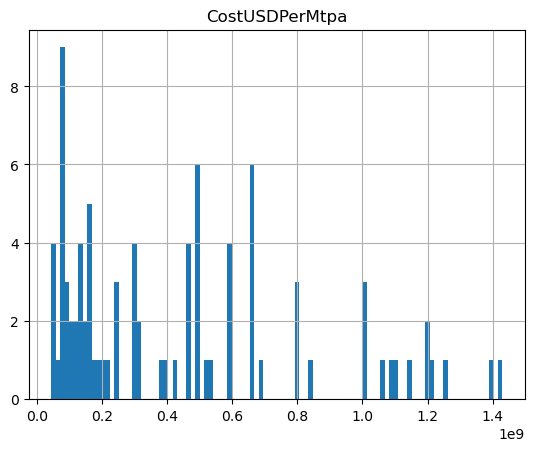

In [14]:
terms_df_floating.hist('CostUSDPerMtpa', bins=100)

array([[<Axes: title={'center': 'CostUSDPerMtpa'}>]], dtype=object)

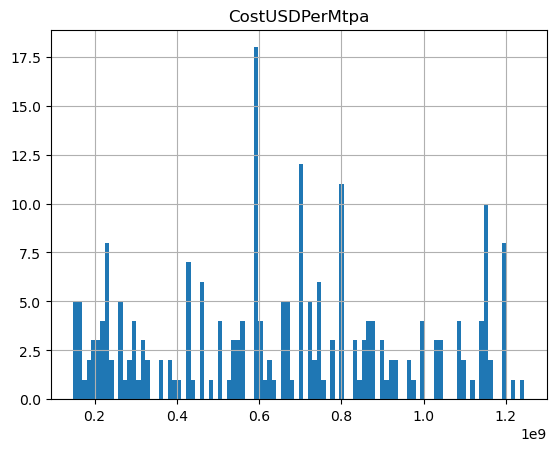

In [15]:
terms_df_onshore.hist('CostUSDPerMtpa', bins=100)

create a "noexpansions" dataframe that removes all expansion projects (assuming these will throw off cost calculations) and only keep one cost data point from each unique TerminalName

In [16]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion', na=False)].drop_duplicates(subset=['TerminalID'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion', na=False)].drop_duplicates(subset=['TerminalID'], keep='first')

## import

In [17]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Tema FSRU,Ghana,Construction,https://www.gem.wiki/Tema_FSRU,205882352.940000
Kutubdia (Reliance) FSRU,Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_(Reliance)_FSRU,84444444.270000
Jawa Satu FSRU,Indonesia,Operating,https://www.gem.wiki/Jawa_Satu_FSRU,145833333.330000
GasPort FSRU,Pakistan,Operating,https://www.gem.wiki/GasPort_FSRU,100000000.000000
Newcastle FSRU,Australia,Shelved,https://www.gem.wiki/Newcastle_FSRU,427833108.000000
Hong Kong FSRU,Hong Kong,Operating,https://www.gem.wiki/Hong_Kong_FSRU,163934426.230000
Eagle FSRU,Albania,Cancelled,https://www.gem.wiki/Eagle_FSRU,134567901.230000
Krk FSRU,Croatia,Operating,https://www.gem.wiki/Krk_FSRU,133187926.030000
Cyprus LNG Terminal,Cyprus,Construction,https://www.gem.wiki/Cyprus_LNG_Terminal,295390000.000000
Wilhelmshaven FSRU,Germany,Operating,https://www.gem.wiki/Wilhelmshaven_FSRU,86052631.580000


In [18]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Jorf Lasfar LNG Terminal,Morocco,Proposed,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,874285632.690000
Lahad Datu Sabah LNG Terminal,Malaysia,Cancelled,https://www.gem.wiki/Lahad_Datu_Sabah_LNG_Terminal,317105263.160000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.710000
Mariveles LNG Terminal,Philippines,Proposed,https://www.gem.wiki/Mariveles_LNG_Terminal,167500000.000000
Singapore LNG Terminal,Singapore,Operating,https://www.gem.wiki/Singapore_LNG_Terminal,161904761.710000
Taichung LNG Terminal,Taiwan,Operating,https://www.gem.wiki/Taichung_LNG_Terminal,357000000.000000
Map Ta Phut LNG Terminal 2,Thailand,Operating,https://www.gem.wiki/Map_Ta_Phut_LNG_Terminal_2,148866666.670000
Thi Vai LNG Terminal,Vietnam,Operating,https://www.gem.wiki/Thi_Vai_LNG_Terminal,285000000.000000
Son My LNG Terminal,Vietnam,Proposed,https://www.gem.wiki/Son_My_LNG_Terminal,233333333.330000
Cacouna LNG Terminal,Canada,Cancelled,https://www.gem.wiki/Cacouna_LNG_Terminal,173684210.530000


## export list

In [19]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Fourchon LNG Terminal,United States,Cancelled,https://www.gem.wiki/Fourchon_LNG_Terminal,444000000.000000
Alaska LNG Terminal,United States,Proposed,https://www.gem.wiki/Alaska_LNG_Terminal,835820895.520000
Annova LNG Brownsville Terminal,United States,Cancelled,https://www.gem.wiki/Annova_LNG_Terminal,462962962.960000
Calcasieu Pass LNG Terminal,United States,Operating,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,591666666.670000
Cameron LNG Terminal,United States,Operating,https://www.gem.wiki/Cameron_LNG_Terminal,740740740.740000
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,430107526.880000
Corpus Christi LNG Terminal,United States,Operating,https://www.gem.wiki/Corpus_Christi_LNG,1033333333.330000
Cove Point LNG Export Terminal,United States,Operating,https://www.gem.wiki/Cove_Point_LNG_Terminal,761904761.900000
Driftwood LNG Terminal,United States,Proposed,https://www.gem.wiki/Driftwood_LNG_Terminal,632530120.480000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,558874221.670000


In [20]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
CE FLNG Terminal,United States,Cancelled,https://www.gem.wiki/CE_FLNG_Terminal,1000000000.000000
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,592592592.590000
Cameroon FLNG Terminal,Cameroon,Operating,https://www.gem.wiki/Cameroon_FLNG_Terminal,500000000.000000
Fortuna FLNG Terminal,Equatorial Guinea,Cancelled,https://www.gem.wiki/Fortuna_FLNG_Terminal,793650793.650000
Liquid Niugini FLNG Terminal,Papua New Guinea,Cancelled,https://www.gem.wiki/Liquid_Niugini_FLNG_Terminal,1400000000.000000
Cedar FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Cedar_FLNG_Terminal,1212121212.120000
Iran FLNG Terminal,Iran,Cancelled,https://www.gem.wiki/Iran_FLNG,1200000000.000000
Eilat FLNG Terminal,Israel,Cancelled,https://www.gem.wiki/Eilat_FLNG_Terminal,1200000000.000000
Tamar FLNG Terminal,Israel,Cancelled,https://www.gem.wiki/Tamar_FLNG_Terminal,1090000000.000000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.140000


### make dataframe to use for terminal calculations

* use regional averages for onshore terminals
* Subregions will inherit larger Region values
  * if Region has fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [21]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()


onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values[0]

onshore_export_regional_costs = onshore_export_regional_costs.loc[~(onshore_export_regional_costs.index=='--')]

print('export onshore')
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,5,7.138391e+08
Americas,34,7.336425e+08
Asia,7,6.808557e+08
Europe,8,8.457898e+08
Oceania,6,7.700058e+08


In [22]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values[0]

onshore_import_regional_costs = onshore_import_regional_costs.loc[~(onshore_import_regional_costs.index=='--')]
print('import onshore')
onshore_import_regional_costs.replace(numpy.nan,0)

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,1.0,3.335138e+08
Americas,4.0,3.017544e+08
Asia,28.0,3.120422e+08
Europe,9.0,3.543440e+08
Oceania,0.0,3.335138e+08


In [23]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values[0]

floating_export_regional_costs = floating_export_regional_costs.loc[~(floating_export_regional_costs.index=='--')]

print('export floating')
floating_export_regional_costs.replace(numpy.nan,0)

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,6,7.793220e+08
Americas,7,7.793220e+08
Asia,5,7.793220e+08
Europe,2,7.793220e+08
Oceania,3,7.793220e+08


In [24]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values[0]

floating_import_regional_costs = floating_import_regional_costs.loc[~(floating_import_regional_costs.index=='--')]

print('import floating')
floating_import_regional_costs.replace(numpy.nan,0)

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,3.0,1.854875e+08
Americas,0.0,1.854875e+08
Asia,14.0,1.854875e+08
Europe,19.0,1.854875e+08
Oceania,4.0,1.854875e+08


### global calculations

In [25]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_mdn = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].median().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_mdn = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].median().values
cost_floating_export_std = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_mdn = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].median().values
cost_onshore_import_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_mdn = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].median().values
cost_floating_import_std = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].std().values

In [26]:
cost_onshore_export

array([7.4442309e+08])

In [27]:
cost_onshore_export_mdn

array([7.38694496e+08])

In [28]:
cost_onshore_export_std

array([2.66785495e+08])

In [29]:
cost_floating_export

array([7.79321978e+08])

In [30]:
cost_floating_export_mdn

array([7.93650794e+08])

In [31]:
cost_floating_export_std

array([4.12653214e+08])

In [32]:
cost_onshore_import

array([3.33513832e+08])

In [33]:
cost_onshore_import_mdn

array([2.53444989e+08])

In [34]:
cost_onshore_import_std

array([2.10696462e+08])

In [35]:
cost_floating_import

array([1.85487546e+08])

In [36]:
cost_floating_import_mdn

array([1.32627781e+08])

In [37]:
cost_floating_import_std

array([1.98165862e+08])

### calculate how much export/import capacity data we have

In [38]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
#terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)
terms_df_costs_exist.shape

(410, 101)

In [39]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(558/663 * 100)

(677, 101)
(572, 101)
84.16289592760181


In [40]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(558/595 * 100)

(618, 101)
(588, 101)
93.78151260504201


## now calculate the import terminal costs

In [41]:
terms_df_import = terms_df_orig.loc[terms_df_orig['FacilityType']=='Import'].reset_index(drop=True)

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostUSD']

## and calculate export terminal costs

In [42]:
terms_df_export = terms_df_orig.loc[terms_df_orig['FacilityType']=='Export'].reset_index(drop=True)

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostUSD']

## import terminal costs table - FOR SUMMARY TABLES

In [43]:
#mtpa by country

cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby(['Region','SubRegion','Country'])['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby(['Region','SubRegion'])['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_region_import_df.index.names = ['Region','Subregion']
cost_by_country_import_df.index.names = ['Region','Subregion','Country']

# total
cost_by_region_import_df.loc[('Total',''),:] = cost_by_region_import_df.sum(axis=0)
cost_by_country_import_df.loc[('Total','',''),:] = cost_by_country_import_df.sum(axis=0)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
(cost_by_country_import_df/1e9).replace(0,'').to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df_full = cost_by_region_import_df.copy()
#cost_by_region_import_df = cost_by_region_import_df.loc[~(cost_by_region_import_df==0).all(axis=1)]
#cost_by_region_import_df = cost_by_region_import_df.sort_values('Region')

(cost_by_region_import_df/1e9).replace(0,'').to_excel('cost-by-region-import-billionUSD.xlsx')
(cost_by_region_import_df/1e9).replace(0,'')

Proposed Construction  \
Region   Subregion                                                 
Africa   Northern Africa                        4.5                
         Sub-Saharan Africa                   1.222     0.813719   
Americas Latin America and the Caribbean   5.924096     1.240321   
         Northern America                  0.015088                
Asia     Central Asia                                              
         Eastern Asia                     40.181408    42.525273   
         South-eastern Asia                7.249771     3.250075   
         Southern Asia                    13.045485     5.303701   
         Western Asia                      2.371521      0.59078   
Europe   Eastern Europe                      0.6758      0.54569   
         Northern Europe                   7.172706        0.763   
         Southern Europe                   8.238671      1.50965   
         Western Europe                    7.873069     4.781111   
Oceania  Australia and New Zealand         1.053384     0.326867   
         Melanesia                                                 
         Micronesia                                                
         Polynesia                                                 
Total                                     99.522999    61.650186   

                                         Proposed+Construction    Shelved  \
Region   Subregion                                                          
Africa   Northern Africa                                   4.5     0.0981   
         Sub-Saharan Africa                           2.035719        0.1   
Americas Latin America and the Caribbean              7.164417   1.973363   
         Northern America                             0.015088              
Asia     Central Asia                                                       
         Eastern Asia                                82.706681  12.211907   
         South-eastern Asia                          10.499845   9.304361   
         Southern Asia                               18.349186   5.031672   
         Western Asia                                 2.962301   0.649206   
Europe   Eastern Europe                                1.22149   0.613964   
         Northern Europe                              7.935706   0.790281   
         Southern Europe                              9.748321              
         Western Europe                               12.65418   1.227928   
Oceania  Australia and New Zealand                    1.380252   0.427833   
         Melanesia                                                          
         Micronesia                                                         
         Polynesia                                                          
Total                                               161.173186  32.428616   

                                           Cancelled   Operating      Idle  \
Region   Subregion                                                           
Africa   Northern Africa                    3.548587    0.779048  1.057279   
         Sub-Saharan Africa                 1.520998                         
Americas Latin America and the Caribbean    7.825306   18.947555  1.409705   
         Northern America                  71.488089   16.409861  3.211901   
Asia     Central Asia                                                        
         Eastern Asia                       23.25604   170.11425             
         South-eastern Asia                16.710333   11.240083             
         Southern Asia                      14.77325   17.096698             
         Western Asia                       3.906043   14.189697  4.181386   
Europe   Eastern Europe                     3.336064    1.776503             
         Northern Europe                    6.425514   13.887094             
         Southern Europe                   15.819525   26.531857             
         Western Europe                     4.393

## export terminal costs table - FOR SUMMARY TABLES

In [44]:
#mtpa by country

cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby(['Region','SubRegion','Country'])['CostUSDTotal'].sum()

for status in status_list:
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby(['Region','SubRegion'])['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_region_export_df.index.names = ['Region','Subregion']

# total
cost_by_region_export_df.loc[('Total',''),:] = cost_by_region_export_df.sum(axis=0)
cost_by_country_export_df.loc[('Total','',''),:] = cost_by_country_export_df.sum(axis=0)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
(cost_by_country_export_df/1e9).replace(0,'').to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df_full = cost_by_region_export_df.copy()
#cost_by_region_export_df = cost_by_region_export_df.loc[~(cost_by_region_export_df==0).all(axis=1)]
#cost_by_region_export_df = cost_by_region_export_df.sort_values('Region')

(cost_by_region_export_df/1e9).replace(0,'').to_excel('cost-by-region-export-billionUSD.xlsx')
(cost_by_region_export_df/1e9).replace(0,'')

Proposed Construction  \
Region   Subregion                                                  
Africa   Northern Africa                                            
         Sub-Saharan Africa               133.886573    12.001305   
Americas Latin America and the Caribbean  113.268196     3.084338   
         Northern America                 241.512057    81.379919   
Asia     Central Asia                                               
         Eastern Asia                                               
         South-eastern Asia                 22.49383         2.02   
         Southern Asia                                  11.021284   
         Western Asia                      27.779772        46.25   
Europe   Eastern Europe                   210.136541    16.666667   
         Northern Europe                                            
         Southern Europe                                            
         Western Europe                                             
Oceania  Australia and New Zealand         25.582039          5.6   
         Melanesia                         17.068674                
         Micronesia                                                 
         Polynesia                                                  
Total                                     791.727682   178.023512   

                                         Proposed+Construction    Shelved  \
Region   Subregion                                                          
Africa   Northern Africa                                                    
         Sub-Saharan Africa                         145.887878   6.337966   
Americas Latin America and the Caribbean            116.352534   1.091051   
         Northern America                           322.891976        8.6   
Asia     Central Asia                                                       
         Eastern Asia                                                       
         South-eastern Asia                           24.51383   1.361711   
         Southern Asia                               11.021284              
         Western Asia                                74.029772  14.978826   
Europe   Eastern Europe                             226.803208        2.0   
         Northern Europe                                                    
         Southern Europe                                                    
         Western Europe                                                     
Oceania  Australia and New Zealand                   31.182039   2.849022   
         Melanesia                                   17.068674              
         Micronesia                                                         
         Polynesia                                                          
Total                                               969.751194  37.218576   

                                           Cancelled   Operating       Idle  \
Region   Subregion                                                            
Africa   Northern Africa                    3.569196   23.742879              
         Sub-Saharan Africa                 7.139329   38.547229              
Americas Latin America and the Caribbean   15.058283    6.914521              
         Northern America                 367.408548   72.864111              
Asia     Central Asia                                   0.136171              
         Eastern Asia                                                         
         South-eastern Asia                 2.008524   39.766067   3.812792   
         Southern Asia                     42.906604                          
         Western Asia                      21.806215   56.930148              
Europe   Eastern Europe                      4.31329   42.134743   8.921333   
         Northern Europe                                6.297521              
         Southern Europe                                                      
         Western

## add import + export costs together

In [45]:
cost_by_region_TOTAL = cost_by_region_import_df_full + cost_by_region_export_df_full

cost_by_region_TOTAL = cost_by_region_TOTAL.loc[~(cost_by_region_TOTAL==0).all(axis=1)]
(cost_by_region_TOTAL/1e9).to_excel('cost-by-region-TOTAL-billionUSD.xlsx')
(cost_by_region_TOTAL/1e9).replace(0,'')

Proposed Construction  \
Region   Subregion                                                  
Africa   Northern Africa                         4.5                
         Sub-Saharan Africa               135.108573    12.815024   
Americas Latin America and the Caribbean  119.192292      4.32466   
         Northern America                 241.527145    81.379919   
Asia     Central Asia                                               
         Eastern Asia                      40.181408    42.525273   
         South-eastern Asia                29.743601     5.270075   
         Southern Asia                     13.045485    16.324984   
         Western Asia                      30.151293     46.84078   
Europe   Eastern Europe                   210.812341    17.212356   
         Northern Europe                    7.172706        0.763   
         Southern Europe                    8.238671      1.50965   
         Western Europe                     7.873069     4.781111   
Oceania  Australia and New Zealand         26.635423     5.926867   
         Melanesia                         17.068674                
Total                                     891.250681   239.673699   

                                         Proposed+Construction    Shelved  \
Region   Subregion                                                          
Africa   Northern Africa                                   4.5     0.0981   
         Sub-Saharan Africa                         147.923597   6.437966   
Americas Latin America and the Caribbean            123.516951   3.064414   
         Northern America                           322.907064        8.6   
Asia     Central Asia                                                       
         Eastern Asia                                82.706681  12.211907   
         South-eastern Asia                          35.013675  10.666073   
         Southern Asia                               29.370469   5.031672   
         Western Asia                                76.992073  15.628032   
Europe   Eastern Europe                             228.024697   2.613964   
         Northern Europe                              7.935706   0.790281   
         Southern Europe                              9.748321              
         Western Europe                               12.65418   1.227928   
Oceania  Australia and New Zealand                    32.56229   3.276855   
         Melanesia                                   17.068674              
Total                                               1130.92438  69.647192   

                                           Cancelled   Operating       Idle  \
Region   Subregion                                                            
Africa   Northern Africa                    7.117783   24.521927   1.057279   
         Sub-Saharan Africa                 8.660327   38.547229              
Americas Latin America and the Caribbean   22.883589   25.862077   1.409705   
         Northern America                 438.896637   89.273972   3.211901   
Asia     Central Asia                                   0.136171              
         Eastern Asia                       23.25604  170.114250              
         South-eastern Asia                18.718857   51.006150   3.812792   
         Southern Asia                     57.679854   17.096698              
         Western Asia                      25.712258   71.119845   4.181386   
Europe   Eastern Europe                     7.649354   43.911246   8.921333   
         Northern Europe                    6.425514   20.184616              
         Southern Europe                   15.819525   26.531857              
         Western Europe                     4.393865   21.054987              
Oceania  Australia and New Zealand         53.860761  179.042026        1.6   
         Melanesia                         11.407024   19.000000              
Total                                     702.481387  797.403050  24.19

In [46]:
cost_by_region_TOTAL.groupby('Region').sum()/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Region,,,,,,,,,
Africa,139.608573,12.815024,152.423597,6.536066,15.778110,63.069156,1.057279,2.284285,5.567945
Americas,360.719437,85.704578,446.424015,11.664414,461.780226,115.136049,4.621607,19.732076,5.220351
Asia,113.121788,110.961112,224.082899,43.537685,125.367009,309.473114,7.994178,5.513590,20.901830
Europe,234.096787,24.266117,258.362904,4.632173,34.288257,111.682705,8.921333,0.000000,1.654921
Oceania,43.704097,5.926867,49.630964,3.276855,65.267785,198.042026,1.600000,0.000000,0.000000
Total,891.250681,239.673699,1130.924380,69.647192,702.481387,797.403050,24.194397,27.529951,33.345047


# cumulative sum 2024 onward

In [47]:
terms_df_export_const_fid = terms_df_orig.loc[(terms_df_orig.FacilityType=='Export')&
                                                ((terms_df_orig.Status.isin(['Operating','Construction'])) |
                                                          (terms_df_orig.FIDStatus=='FID'))]

In [48]:
#terms_df_export_const_fid.to_excel('terminals-for-cumulative-sum-Dec1-2023.xlsx')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/619005716.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


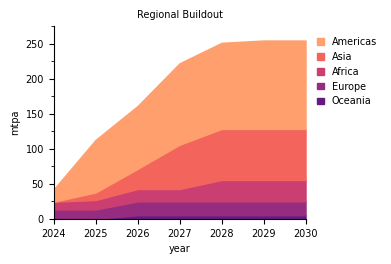

In [49]:
# fill up new capacities as they come online

start_year = 2024
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_americas = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('Region')['CapacityInMtpa'].sum()
    
    terms_df_export_const_fid_subset_americas = terms_df_export_const_fid.loc[(terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export_const_fid.Region=='Americas')]
    mtpa_sum_americas[yr_idx:] += terms_df_export_const_fid_subset_americas['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

region_list = mtpa_sum_regional_cumsum.columns.values

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))
#fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

#new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.3,0.8,region_list.__len__())]

for region_idx in range(region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        color=region_colors[region_idx], 
                        label=region_list[region_idx])
    # else:
    #     if new_region_list[region_idx]=='North America':
    #         ax.fill_between(year_list, 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]], 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     color=matplotlib.cm.get_cmap('magma')(0.2), 
    #                     label='Other North America')
    #         ax.fill_between(year_list,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
    #                     color=matplotlib.cm.get_cmap('magma')(0.3), 
    #                     label='United States')    
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[region_list[region_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[region_list[region_idx]], 
                    color=region_colors[region_idx], 
                    label=region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
#ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
#ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

#mp.savefig('saved-figures/mtpa-regional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/mtpa-regional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
#mp.savefig('saved-figures/mtpa-regional-export-timeseries.svg', bbox_inches='tight', transparent=True)

# FIGURE - CUMSUM FOR 5 LEADING COUNTRIES

In [50]:
start_year = 2024
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_country = pandas.DataFrame(0.0, columns=country_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_country.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('Country')['CapacityInMtpa'].sum()

mtpa_sum_country.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_country_cumsum = mtpa_sum_country.cumsum()
mtpa_sum_country_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_country_cumsum_relative_vals = mtpa_sum_country_cumsum.cumsum(axis=1)
mtpa_sum_country_cumsum_relative_vals = mtpa_sum_country_cumsum_relative_vals.loc[:, (mtpa_sum_country_cumsum_relative_vals != 0).any(axis=0)]

## print out values

In [51]:
mtpa_sum_country_cumsum.loc[:, (mtpa_sum_country_cumsum != 0).any(axis=0)]

,Gabon,Malaysia,Mauritania,Republic of the Congo,Australia,Mexico,United Arab Emirates,Nigeria,Iran,Mozambique,Russia,Canada,Qatar,United States
2024,0.0,0.0,2.52,0.6,0.0,2.80,0.0,8.0,0.0,0.0,13.2,0.0,0.0,14.83
2025,0.0,0.0,2.52,3.0,0.0,2.80,0.0,8.0,10.8,0.0,13.2,28.0,0.0,44.40
2026,0.7,0.0,2.52,3.0,5.0,7.45,0.0,11.4,12.3,0.0,19.8,28.0,16.5,54.40
2027,0.7,2.0,2.52,3.0,5.0,7.45,0.0,11.4,12.3,0.0,19.8,30.1,49.0,78.76
2028,0.7,2.0,2.52,3.0,5.0,7.45,9.6,11.4,12.3,12.9,19.8,30.1,49.0,85.51
2029,0.7,2.0,2.52,3.0,5.0,7.45,9.6,11.4,12.3,12.9,19.8,33.4,49.0,85.51
2030,0.7,2.0,2.52,3.0,5.0,7.45,9.6,11.4,12.3,12.9,19.8,33.4,49.0,85.51


In [52]:
mtpa_sum_country_cumsum.cumsum(axis=1)

,Afghanistan,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Niue,Norfolk Island,...,Australia,Mexico,United Arab Emirates,Nigeria,Iran,Mozambique,Russia,Canada,Qatar,United States
2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.12,5.92,5.92,13.92,13.92,13.92,27.12,27.12,27.12,41.95
2025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.52,8.32,8.32,16.32,27.12,27.12,40.32,68.32,68.32,112.72
2026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.22,18.67,18.67,30.07,42.37,42.37,62.17,90.17,106.67,161.07
2027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.22,20.67,20.67,32.07,44.37,44.37,64.17,94.27,143.27,222.03
2028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.22,20.67,30.27,41.67,53.97,66.87,86.67,116.77,165.77,251.28
2029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.22,20.67,30.27,41.67,53.97,66.87,86.67,120.07,169.07,254.58
2030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.22,20.67,30.27,41.67,53.97,66.87,86.67,120.07,169.07,254.58


In [53]:
top_n = 8
mtpa_sum_country_cumsum_top_n = mtpa_sum_country_cumsum.iloc[:,-top_n:]
mtpa_sum_country_cumsum_the_rest = mtpa_sum_country_cumsum.iloc[:,:-top_n]

mtpa_sum_country_cumsum_relative_vals_top_n = mtpa_sum_country_cumsum.cumsum(axis=1).iloc[:,-top_n:]
#mtpa_sum_country_cumsum_relative_vals_top_n = mtpa_sum_country_cumsum_relative_vals_top_n.loc[:, (mtpa_sum_country_cumsum_relative_vals_top_n != 0).any(axis=0)]
mtpa_sum_country_cumsum_relative_vals_top_n

,United Arab Emirates,Nigeria,Iran,Mozambique,Russia,Canada,Qatar,United States
2024,5.92,13.92,13.92,13.92,27.12,27.12,27.12,41.95
2025,8.32,16.32,27.12,27.12,40.32,68.32,68.32,112.72
2026,18.67,30.07,42.37,42.37,62.17,90.17,106.67,161.07
2027,20.67,32.07,44.37,44.37,64.17,94.27,143.27,222.03
2028,30.27,41.67,53.97,66.87,86.67,116.77,165.77,251.28
2029,30.27,41.67,53.97,66.87,86.67,120.07,169.07,254.58
2030,30.27,41.67,53.97,66.87,86.67,120.07,169.07,254.58


## relative values for "the rest"

In [54]:
mtpa_sum_country_cumsum_relative_vals_the_rest = pandas.DataFrame(mtpa_sum_country_cumsum_the_rest.sum(axis=1))
mtpa_sum_country_cumsum_relative_vals_the_rest.rename(columns={0:'Other'}, inplace=True)
mtpa_sum_country_cumsum_relative_vals_the_rest

,Other
2024,5.92
2025,8.32
2026,18.67
2027,20.67
2028,20.67
2029,20.67
2030,20.67


In [55]:
mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n = pandas.concat([mtpa_sum_country_cumsum_relative_vals_the_rest,
                                                                          mtpa_sum_country_cumsum_relative_vals_top_n], axis=1)

mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n

,Other,United Arab Emirates,Nigeria,Iran,Mozambique,Russia,Canada,Qatar,United States
2024,5.92,5.92,13.92,13.92,13.92,27.12,27.12,27.12,41.95
2025,8.32,8.32,16.32,27.12,27.12,40.32,68.32,68.32,112.72
2026,18.67,18.67,30.07,42.37,42.37,62.17,90.17,106.67,161.07
2027,20.67,20.67,32.07,44.37,44.37,64.17,94.27,143.27,222.03
2028,20.67,30.27,41.67,53.97,66.87,86.67,116.77,165.77,251.28
2029,20.67,30.27,41.67,53.97,66.87,86.67,120.07,169.07,254.58
2030,20.67,30.27,41.67,53.97,66.87,86.67,120.07,169.07,254.58


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/1380259723.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


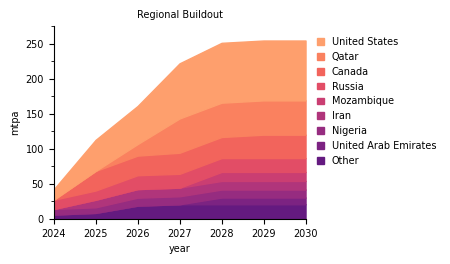

In [56]:
# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))
#fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

#new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
wedge_list = mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n.columns.tolist()
wedge_colors = [sel_cmap(i) for i in numpy.linspace(0.3,0.8,wedge_list.__len__())]

for wedge_idx in range(wedge_list.__len__()):
    if wedge_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n[wedge_list[wedge_idx]],
                        color=wedge_colors[wedge_idx], 
                        label=wedge_list[wedge_idx])
    # else:
    #     if new_region_list[region_idx]=='North America':
    #         ax.fill_between(year_list, 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]], 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     color=matplotlib.cm.get_cmap('magma')(0.2), 
    #                     label='Other North America')
    #         ax.fill_between(year_list,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
    #                     color=matplotlib.cm.get_cmap('magma')(0.3), 
    #                     label='United States')    
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n[wedge_list[wedge_idx-1]],
                    mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n[wedge_list[wedge_idx]], 
                    color=wedge_colors[wedge_idx], 
                    label=wedge_list[wedge_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
#ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
#ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# mp.savefig('saved-figures/mtpa-regional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-regional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
# mp.savefig('saved-figures/mtpa-regional-export-timeseries.svg', bbox_inches='tight', transparent=True)

# same but for subregions

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/3447711055.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


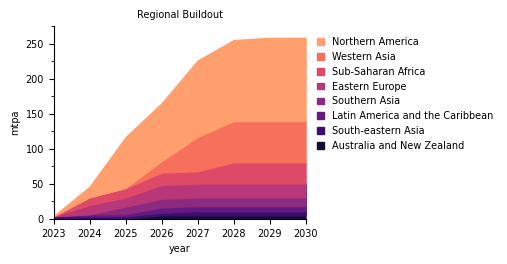

In [57]:
# fill up new capacities as they come online
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=subregion_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_americas = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('SubRegion')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
#eliminate all-zero columns
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

new_subregion_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.1,0.8,new_subregion_list.__len__())]

for subregion_idx in range(new_subregion_list.__len__()):
    if subregion_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[region_idx]],
                        color=region_colors[subregion_idx], 
                        label=new_subregion_list[subregion_idx])
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx]], 
                    color=region_colors[subregion_idx], 
                    label=new_subregion_list[subregion_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

#mp.savefig('saved-figures/mtpa-subregional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/mtpa-subregional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
#mp.savefig('saved-figures/mtpa-subregional-export-timeseries.svg', bbox_inches='tight', transparent=True)

In [58]:
mtpa_sum_regional_cumsum.loc[:,(mtpa_sum_regional_cumsum!= 0).any(axis=0)]

,Australia and New Zealand,South-eastern Asia,Latin America and the Caribbean,Southern Asia,Eastern Europe,Sub-Saharan Africa,Western Asia,Northern America
2023,0.0,3.8,0.00,0.0,0.0,0.00,0.0,0.00
2024,0.0,3.8,2.80,0.0,13.2,11.12,0.0,14.83
2025,0.0,3.8,2.80,10.8,13.2,13.52,0.0,72.40
2026,5.0,3.8,7.45,12.3,19.8,17.62,16.5,82.40
2027,5.0,5.8,7.45,12.3,19.8,17.62,49.0,108.86
2028,5.0,5.8,7.45,12.3,19.8,30.52,58.6,115.61
2029,5.0,5.8,7.45,12.3,19.8,30.52,58.6,118.91
2030,5.0,5.8,7.45,12.3,19.8,30.52,58.6,118.91


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/4182831547.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/4182831547.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color=matplotlib.cm.get_cmap('magma')(0.3),
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65231/4182831547.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``py

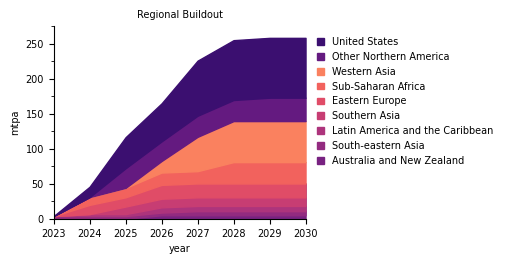

In [59]:
# fill up new capacities as they come online
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=subregion_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('SubRegion')['CapacityInMtpa'].sum()
    
    terms_df_export_subset_usa = terms_df_export_const_fid.loc[(terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export_const_fid.Country=='United States')]
    
    mtpa_sum_usa[yr_idx:] += terms_df_export_subset_usa['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
#eliminate all-zero columns
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

mtpa_sum_rest_of_nam = mtpa_sum_regional_cumsum['Northern America'].values - mtpa_sum_usa

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

new_subregion_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.35,0.8,new_subregion_list.__len__())]

for subregion_idx in range(new_subregion_list.__len__()):
    if subregion_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[region_idx]],
                        color=region_colors[subregion_idx], 
                        label=new_subregion_list[subregion_idx])
    elif new_subregion_list[subregion_idx]=='Northern America':
            #pass
            #do the north america not USA chunk
            ax.fill_between(year_list, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]], 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam,
                        color=matplotlib.cm.get_cmap('magma')(0.3), 
                        label='Other Northern America')
            ax.fill_between(year_list,
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam,
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
                        color=matplotlib.cm.get_cmap('magma')(0.2), 
                        label='United States')   
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx]], 
                    color=region_colors[subregion_idx], 
                    label=new_subregion_list[subregion_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

#mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.pdf', bbox_inches='tight', transparent=True)
#mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.svg', bbox_inches='tight', transparent=True)

In [60]:
mtpa_sum_regional_cumsum_byregion

,Australia and New Zealand,South-eastern Asia,Latin America and the Caribbean,Southern Asia,Eastern Europe,Sub-Saharan Africa,Western Asia,Northern America
2023,0.0,3.8,3.80,3.80,3.80,3.80,3.80,3.80
2024,0.0,3.8,6.60,6.60,19.80,30.92,30.92,45.75
2025,0.0,3.8,6.60,17.40,30.60,44.12,44.12,116.52
2026,5.0,8.8,16.25,28.55,48.35,65.97,82.47,164.87
2027,5.0,10.8,18.25,30.55,50.35,67.97,116.97,225.83
2028,5.0,10.8,18.25,30.55,50.35,80.87,139.47,255.08
2029,5.0,10.8,18.25,30.55,50.35,80.87,139.47,258.38
2030,5.0,10.8,18.25,30.55,50.35,80.87,139.47,258.38


In [61]:
pandas.DataFrame(numpy.column_stack((mtpa_sum_usa,mtpa_sum_rest_of_nam)), index=range(2023,2031), columns=['United States', 'Other Northern America'])

,United States,Other Northern America
2023,0.00,0.0
2024,14.83,0.0
2025,44.40,28.0
2026,54.40,28.0
2027,78.76,30.1
2028,85.51,30.1
2029,85.51,33.4
2030,85.51,33.4


# final read-through report number checks

In [62]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Operating']))&
                  (terms_df_orig.StartYear1.isin([2022,2023]))&
                  (terms_df_orig['FacilityType']=='Import')]['CapacityInMtpa'].sum()

np.float64(137.17999999999998)

In [63]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Operating']))&
                  (terms_df_orig.StartYear1.isin([2022,2023]))&
                  (terms_df_orig['FacilityType']=='Export')]['CapacityInMtpa'].sum()

np.float64(16.060000000000002)

In [64]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.Delayed=='Yes')]['CapacityInMtpa'].sum()

np.float64(0.0)

In [65]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Shelved']))]['CapacityInMtpa'].sum()

np.float64(186.82)

In [66]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Shelved']))&
                  (terms_df_orig.ShelvedYear.isin([2022,2023]))]['CapacityInMtpa'].sum()

np.float64(71.32)

In [67]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Cancelled']))&
                  (terms_df_orig.CancelledYear.isin([2022,2023]))]['CapacityInMtpa'].sum()

np.float64(163.79000000000002)

In [68]:
cost_by_country_export_df

Proposed  \
Region   Subregion                       Country                               
Africa   Northern Africa                 Algeria                0.000000e+00   
                                         Egypt                  0.000000e+00   
                                         Libya                  0.000000e+00   
         Sub-Saharan Africa              Angola                 0.000000e+00   
                                         Cameroon               5.000000e+08   
                                         Djibouti               0.000000e+00   
                                         Equatorial Guinea      1.500000e+09   
                                         Gabon                  1.000000e+09   
                                         Mauritania             1.058839e+10   
                                         Mozambique             4.900000e+10   
                                         Nigeria                2.215979e+10   
                                         Republic of the Congo  0.000000e+00   
                                         Senegal                7.138391e+09   
                                         Tanzania               4.200000e+10   
Americas Latin America and the Caribbean Argentina              5.663150e+10   
                                         Brazil                 0.000000e+00   
                                         Colombia               0.000000e+00   
                                         Mexico                 5.123670e+10   
                                         Peru                   0.000000e+00   
                                         Suriname               5.400000e+09   
                                         Trinidad and Tobago    0.000000e+00   
                                         Venezuela              0.000000e+00   
         Northern America                Canada                 4.255097e+10   
                                         United States          1.989611e+11   
Asia     Central Asia                    Turkmenistan           0.000000e+00   
         South-eastern Asia              Brunei                 0.000000e+00   
                                         Indonesia              2.093519e+10   
                                         Malaysia               1.558644e+09   
         Southern Asia                   Iran                   0.000000e+00   
         Western Asia                    Cyprus                 0.000000e+00   
                                         Israel                 4.350000e+08   
                                         Kuwait                 0.000000e+00   
                                         Oman                   2.451081e+09   
                                         Qatar                  1.089369e+10   
                                         United Arab Emirates   1.400000e+10   
                                         Yemen                  0.000000e+00   
Europe   Eastern Europe                  Russia                 2.101365e+11   
         Northern Europe                 Norway                 0.000000e+00   
Oceania  Australia and New Zealand       Australia              2.558204e+10   
         Melanesia                       Papua New Guinea       1.706867e+10   
Total                                                           7.917277e+11   

                                                                Construction  \
Region   Subregion                       Country                               
Africa   Northern Africa                 Algeria                0.000000e+00   
                                         Egypt                  0.000000e+00   
                                         Libya                  0.000000e+00   
         Sub-Saharan Africa              Angola                 0.000000e+00   
                                         Cameroon               0.000000e+00   
                                         Djibouti               0.0